In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

We’ll generate 1,000 values from the sine function and use that as training data. But, we’ll add a little bit of zing to it:

In [2]:
time = np.arange(0,100,0.1)
sin = np.sin(time) + np.random.normal(scale = 0.5, size = len(time))
# A random value, drawn from a normal distribution, is added to each data point. 
# That’ll make the job of our model a bit harder.

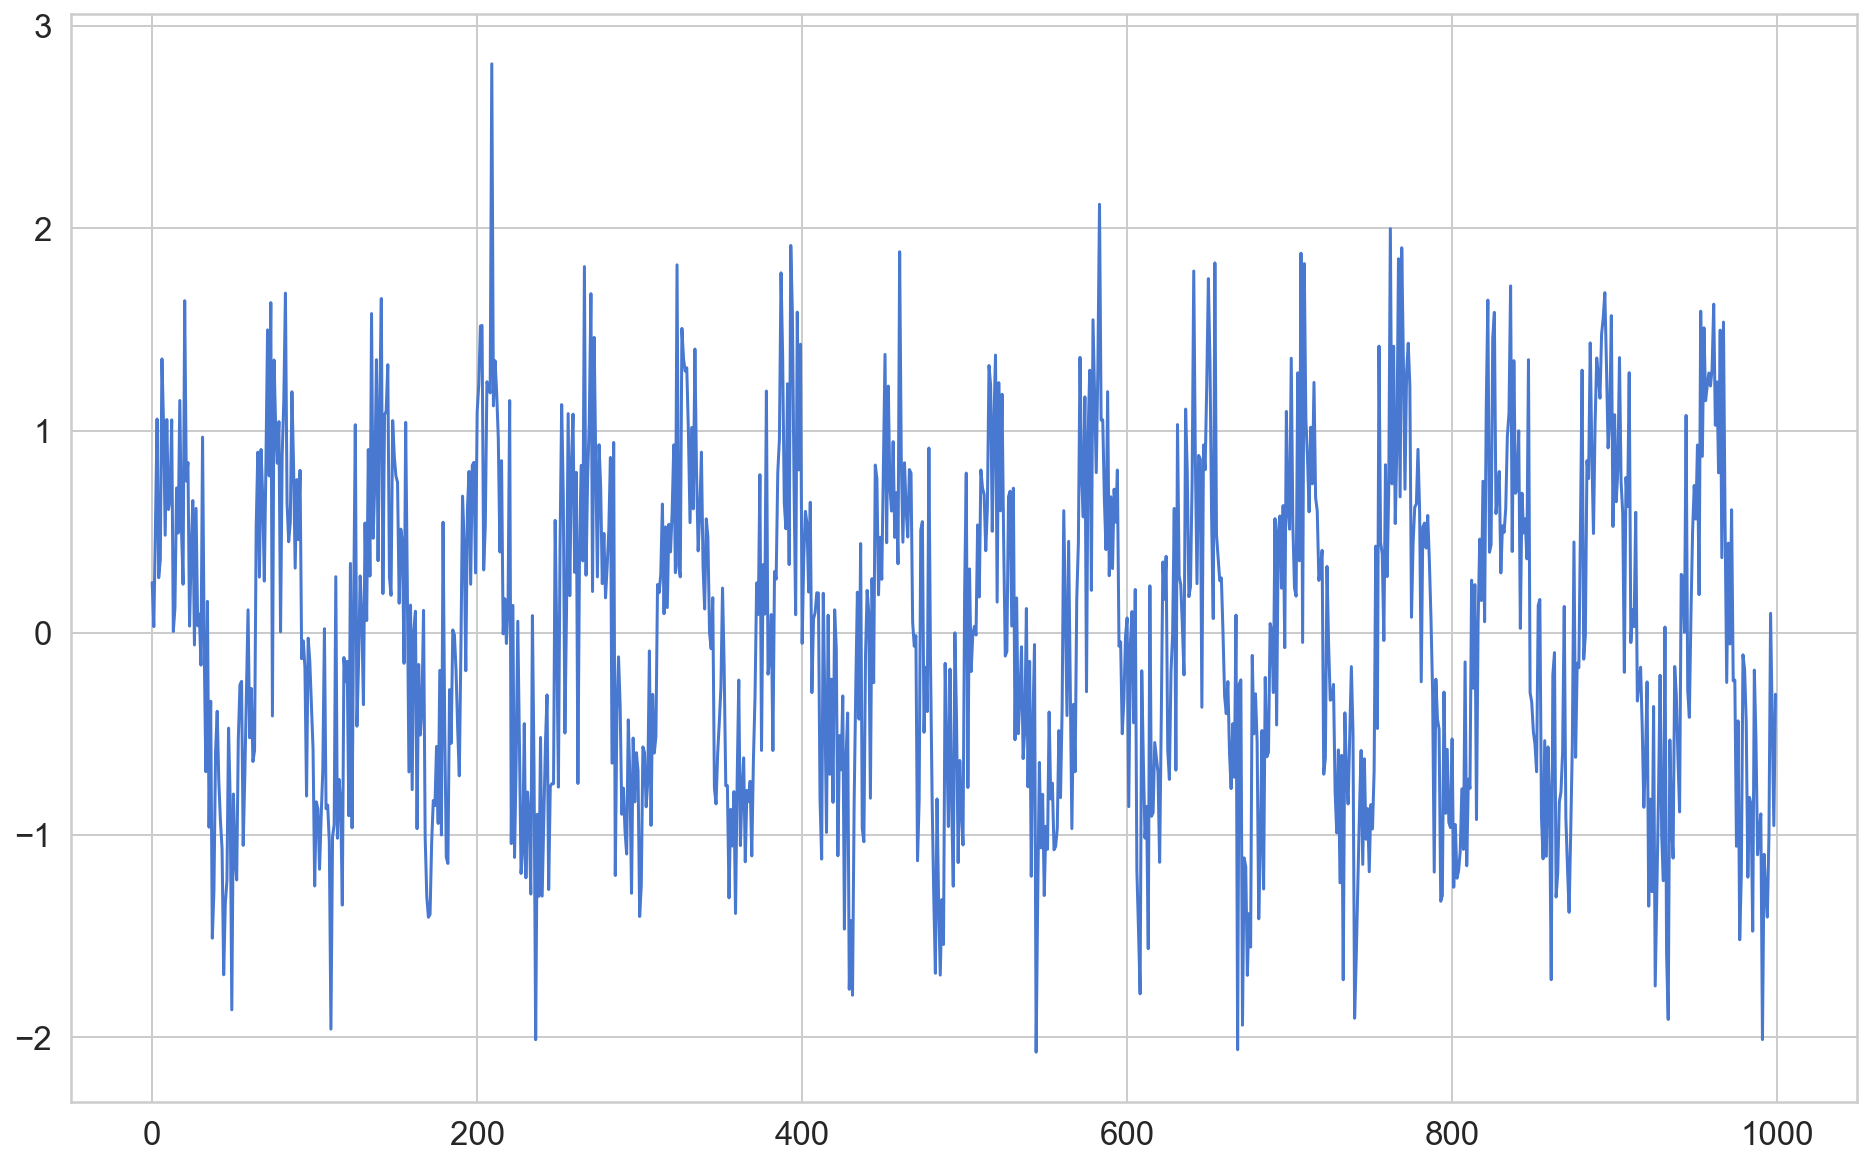

In [3]:
plt.plot(sin)

We need to “chop the data” into smaller sequences for our model. But first, we’ll split it into training and test data:

In [4]:
df = pd.DataFrame(dict(sine=sin), index = time, columns = ['sine'])

train_size = int(len(df)*0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


Preparing the data for Time Series forecasting (LSTMs in particular) can be tricky. Intuitively, we need to predict the value at the current time step by using the history (n time steps from it). Here’s a generic function that does the job:

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data. Let’s use a history of 10 time steps to make our sequences:

In [6]:
time_steps = 10

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape) #samples, time_steps, features

(790, 10, 1) (790,)


Training an LSTM model in Keras is easy. We’ll use the LSTM layer in a sequential model to make our predictions:

In [7]:
model = keras.Sequential([
    keras.layers.LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dense(units = 1)
])

adam = keras.optimizers.Adam(0.001) #lr

model.compile(loss = 'mean_squared_error', optimizer = adam)

The LSTM layer expects the number of time steps and the number of features to work properly. The rest of the model looks like a regular regression model. How do we train a LSTM model?

The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters). The rest is pretty standard:

In [8]:
num_epochs = 30
batch_size = 16

history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_split = 0.1,
                   verbose = 2, shuffle = False)  #shuffle always FALSE with time series data!!!

Epoch 1/30
45/45 - 1s - loss: 0.4394 - val_loss: 0.3740
Epoch 2/30
45/45 - 1s - loss: 0.3324 - val_loss: 0.3310
Epoch 3/30
45/45 - 1s - loss: 0.3219 - val_loss: 0.3254
Epoch 4/30
45/45 - 1s - loss: 0.3199 - val_loss: 0.3217
Epoch 5/30
45/45 - 1s - loss: 0.3184 - val_loss: 0.3191
Epoch 6/30
45/45 - 1s - loss: 0.3173 - val_loss: 0.3171
Epoch 7/30
45/45 - 1s - loss: 0.3165 - val_loss: 0.3154
Epoch 8/30
45/45 - 1s - loss: 0.3157 - val_loss: 0.3140
Epoch 9/30
45/45 - 1s - loss: 0.3150 - val_loss: 0.3126
Epoch 10/30
45/45 - 1s - loss: 0.3144 - val_loss: 0.3113
Epoch 11/30
45/45 - 1s - loss: 0.3137 - val_loss: 0.3100
Epoch 12/30
45/45 - 1s - loss: 0.3130 - val_loss: 0.3088
Epoch 13/30
45/45 - 1s - loss: 0.3123 - val_loss: 0.3078
Epoch 14/30
45/45 - 0s - loss: 0.3117 - val_loss: 0.3071
Epoch 15/30
45/45 - 1s - loss: 0.3112 - val_loss: 0.3064
Epoch 16/30
45/45 - 1s - loss: 0.3108 - val_loss: 0.3059
Epoch 17/30
45/45 - 1s - loss: 0.3105 - val_loss: 0.3056
Epoch 18/30
45/45 - 1s - loss: 0.3103 - 

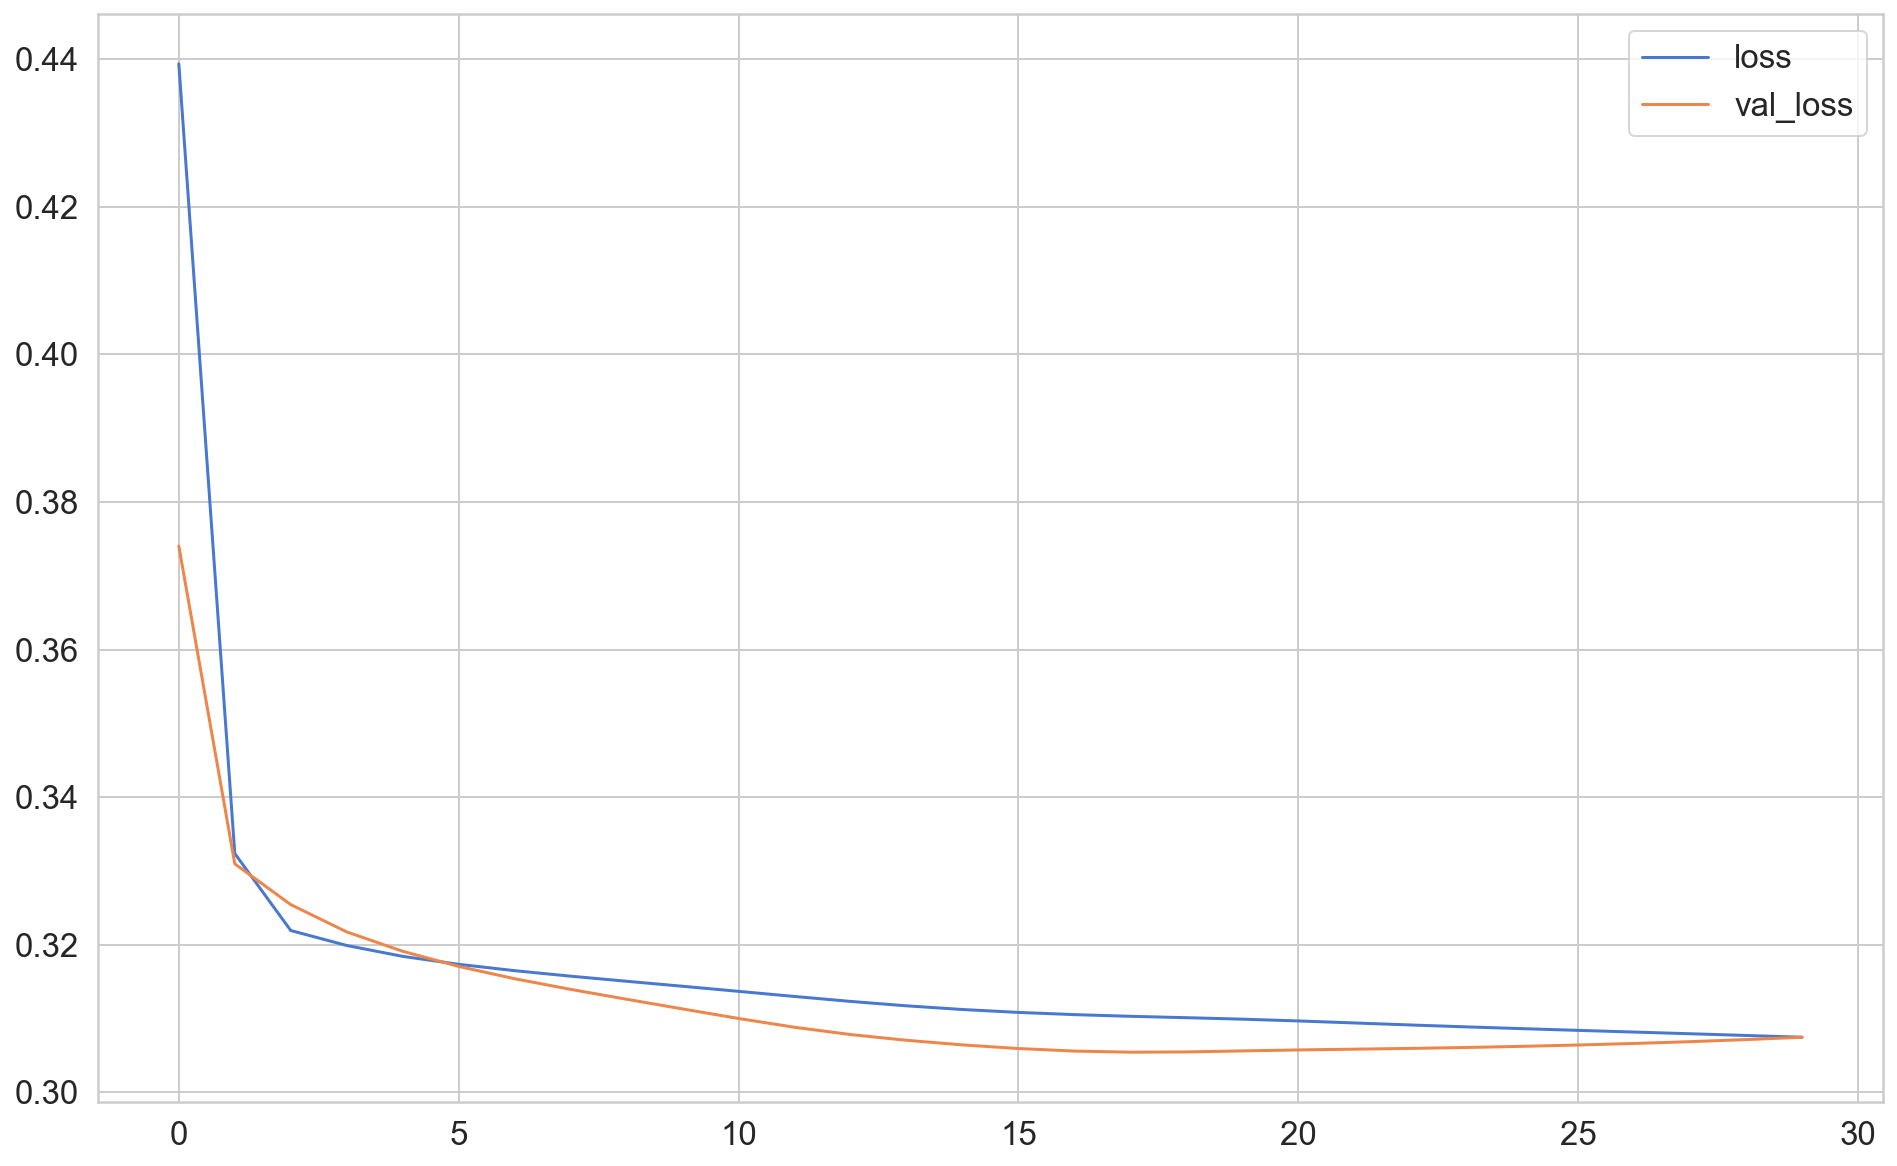

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'], loc = 'upper right')

In [10]:
#evaluation
y_pred = model.predict(X_test)

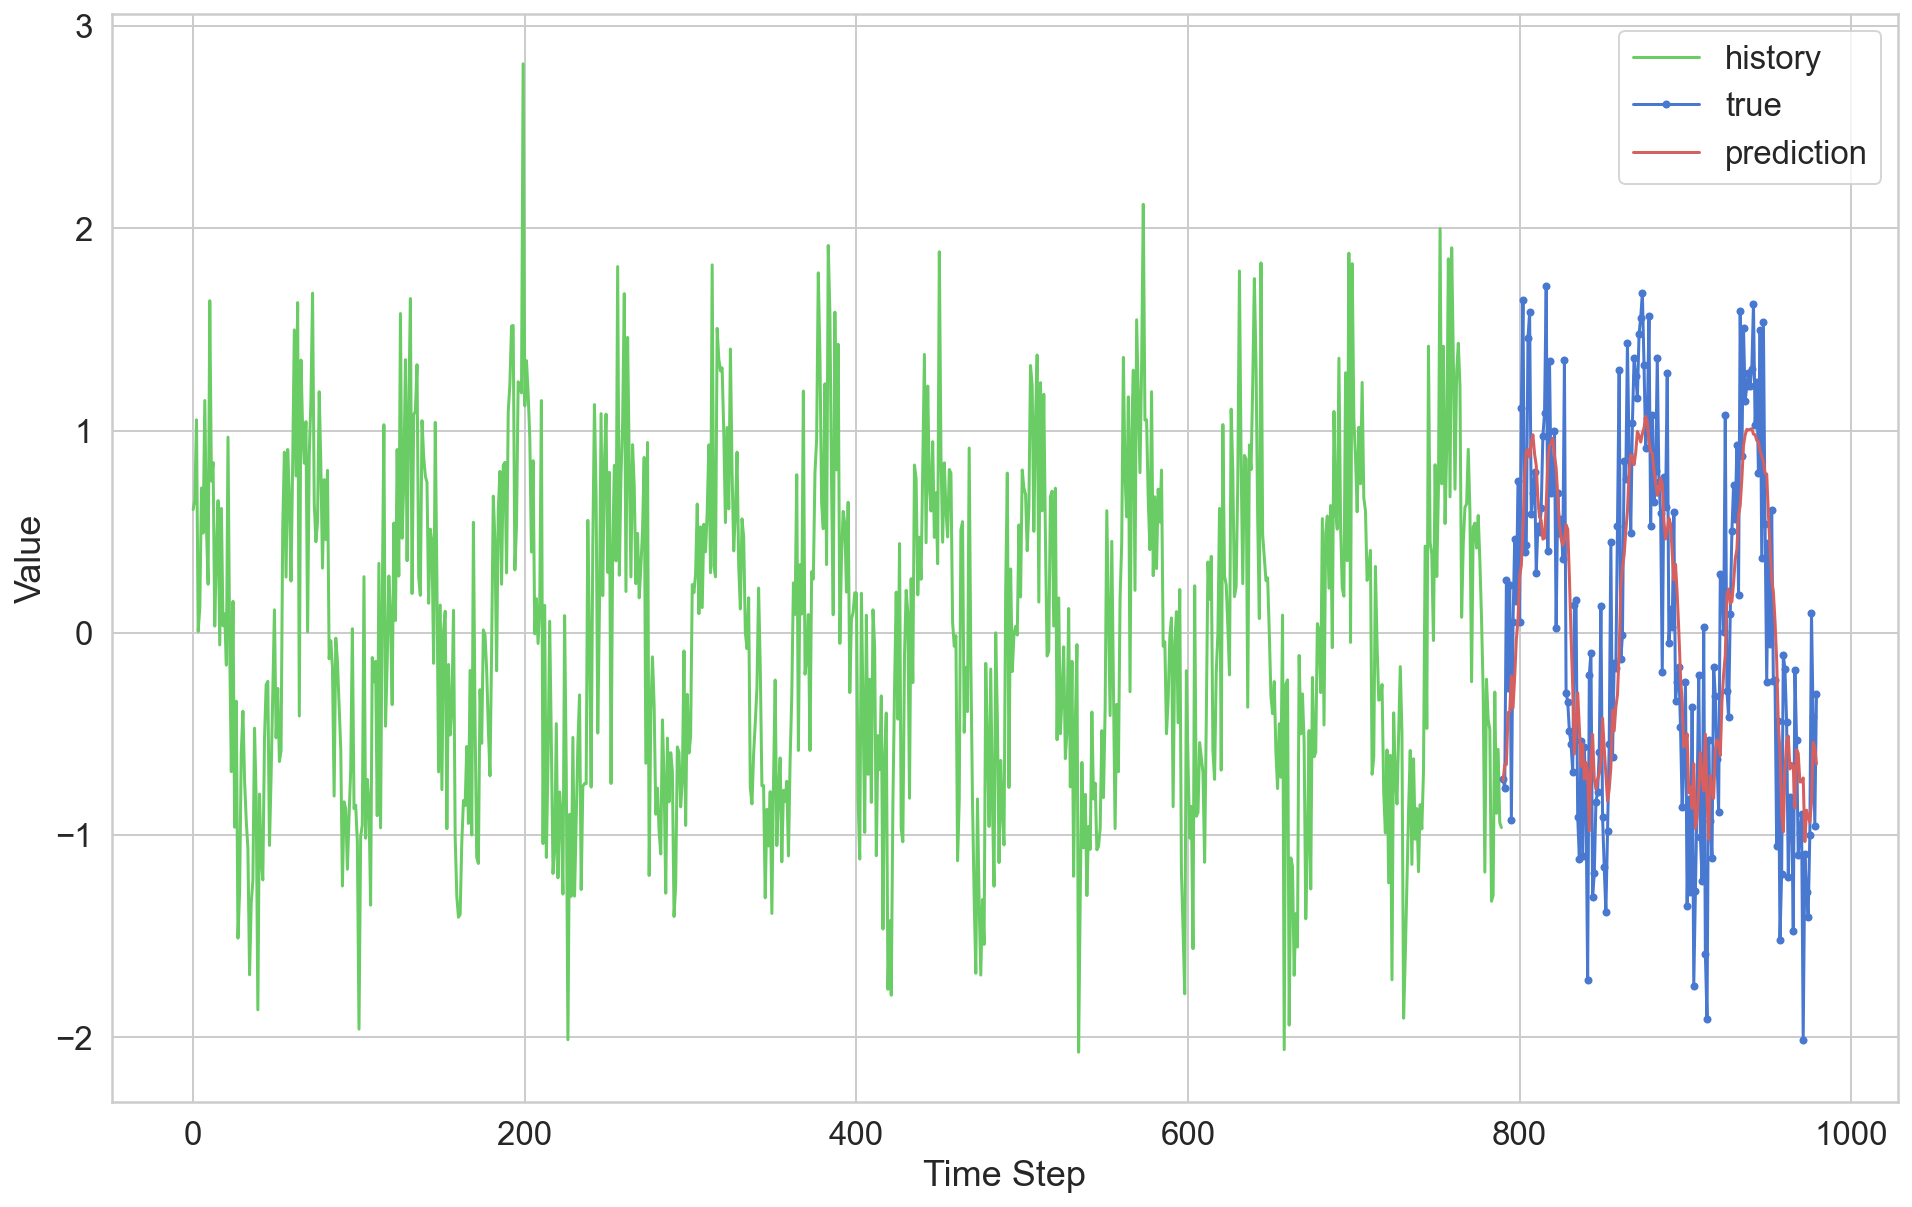

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label = 'history')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, marker = '.', label = 'true')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, 'r', label = 'prediction')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

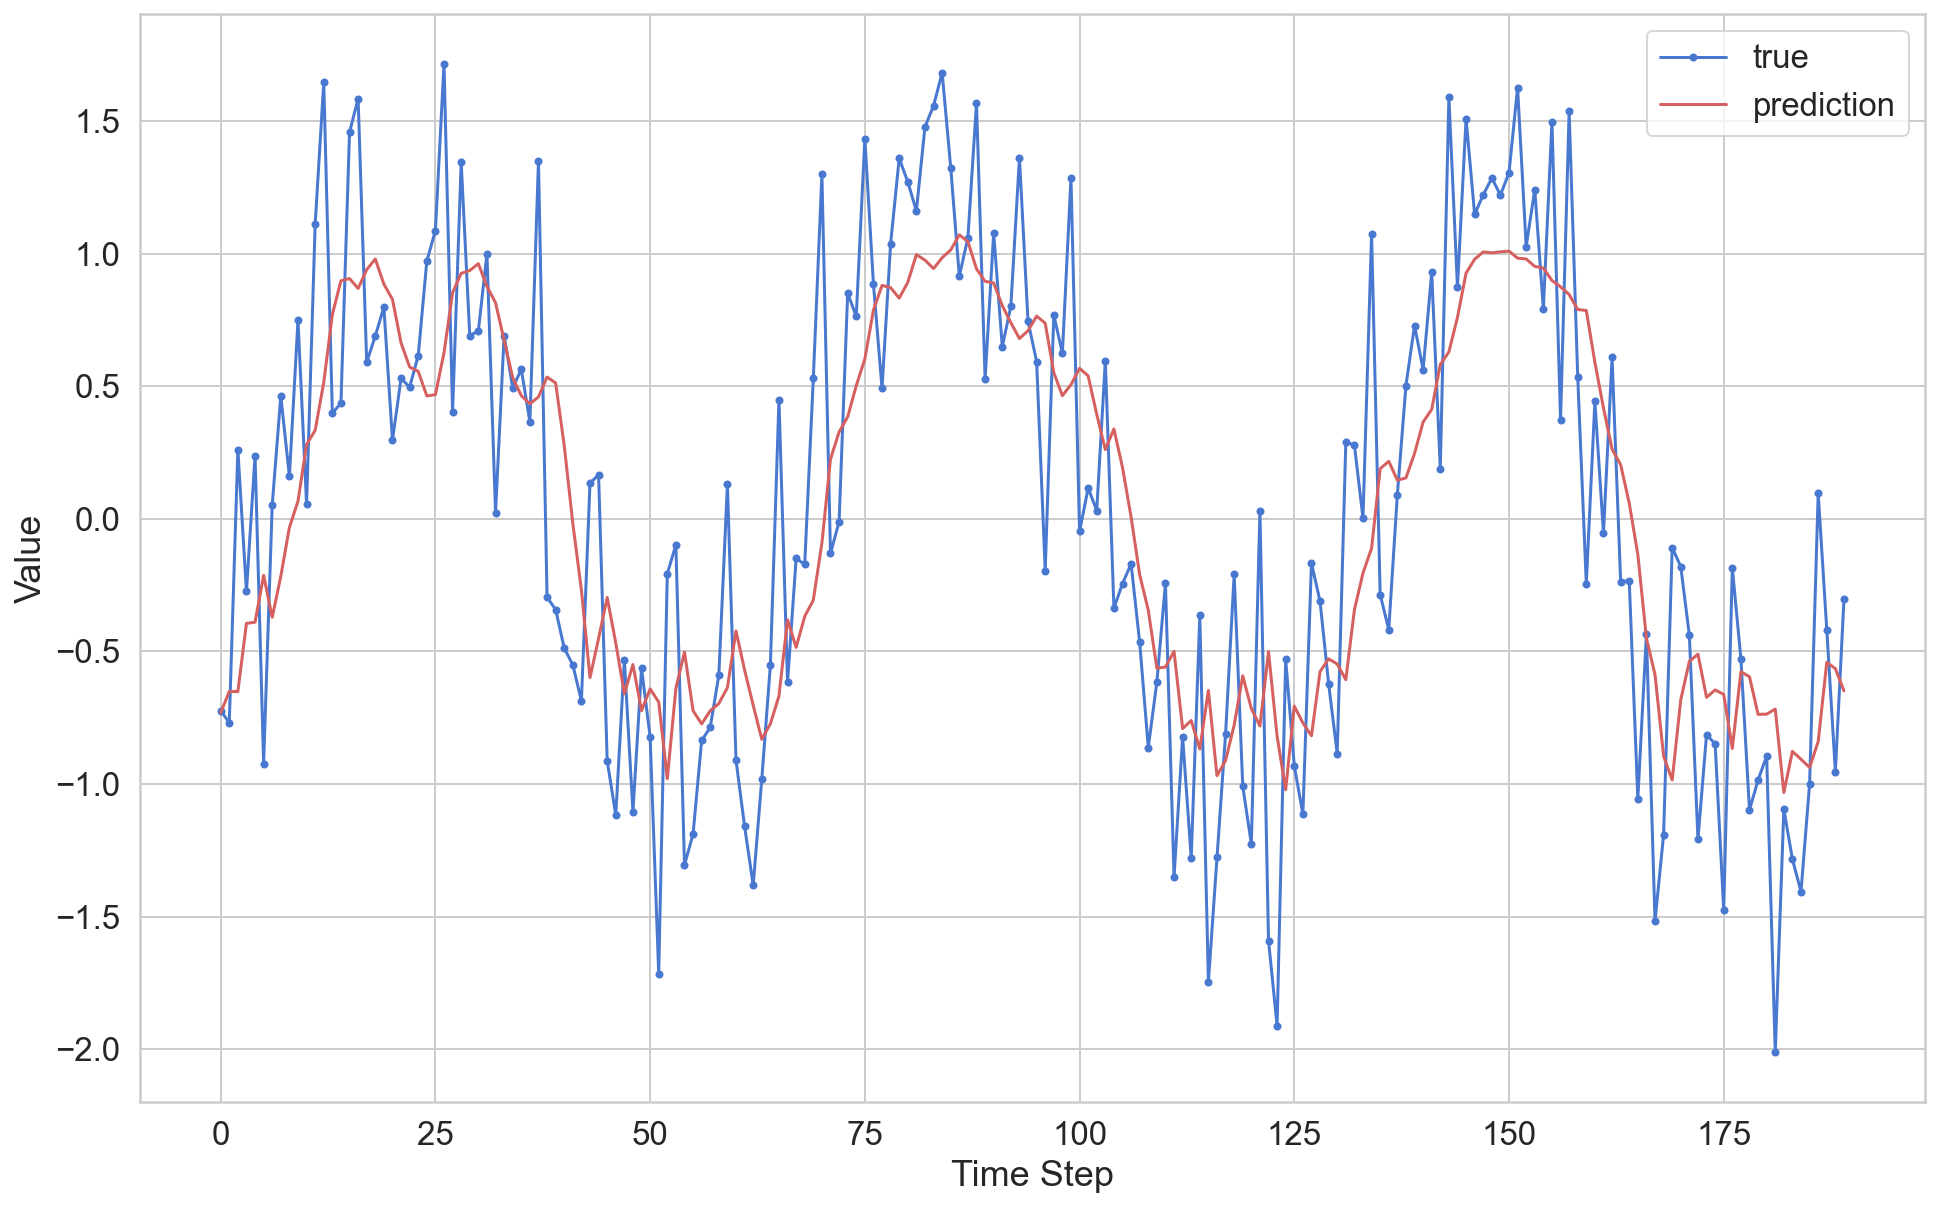

In [12]:
#let's zoom in
plt.plot(y_test, marker = '.', label = 'true')
plt.plot(y_pred, 'r', label = 'prediction')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

The model seems to be doing a great job of capturing the general pattern of the data. It fails to capture random fluctuations, which is a good thing (it generalizes well).

NOTE : You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence input.

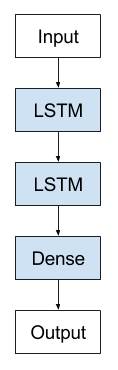

In [13]:
model2 = keras.Sequential([
    keras.layers.LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True),
    keras.layers.LSTM(units = 128),
    keras.layers.Dense(units = 1)
])

#adam = keras.optimizers.Adam(0.001) #lr

model2.compile(loss = 'mean_squared_error', optimizer = adam)

In [14]:
history = model2.fit(X_train, y_train, epochs = 15, batch_size = batch_size, validation_split = 0.1,
                   verbose = 2, shuffle = False)  #shuffle always FALSE with time series data!!!

Epoch 1/15
45/45 - 2s - loss: 0.3654 - val_loss: 0.3260
Epoch 2/15
45/45 - 1s - loss: 0.3211 - val_loss: 0.3141
Epoch 3/15
45/45 - 1s - loss: 0.3169 - val_loss: 0.3139
Epoch 4/15
45/45 - 1s - loss: 0.3140 - val_loss: 0.3129
Epoch 5/15
45/45 - 1s - loss: 0.3124 - val_loss: 0.3128
Epoch 6/15
45/45 - 1s - loss: 0.3114 - val_loss: 0.3124
Epoch 7/15
45/45 - 1s - loss: 0.3108 - val_loss: 0.3110
Epoch 8/15
45/45 - 1s - loss: 0.3102 - val_loss: 0.3100
Epoch 9/15
45/45 - 1s - loss: 0.3097 - val_loss: 0.3096
Epoch 10/15
45/45 - 1s - loss: 0.3093 - val_loss: 0.3097
Epoch 11/15
45/45 - 1s - loss: 0.3089 - val_loss: 0.3100
Epoch 12/15
45/45 - 1s - loss: 0.3084 - val_loss: 0.3105
Epoch 13/15
45/45 - 1s - loss: 0.3079 - val_loss: 0.3109
Epoch 14/15
45/45 - 1s - loss: 0.3073 - val_loss: 0.3112
Epoch 15/15
45/45 - 1s - loss: 0.3066 - val_loss: 0.3112


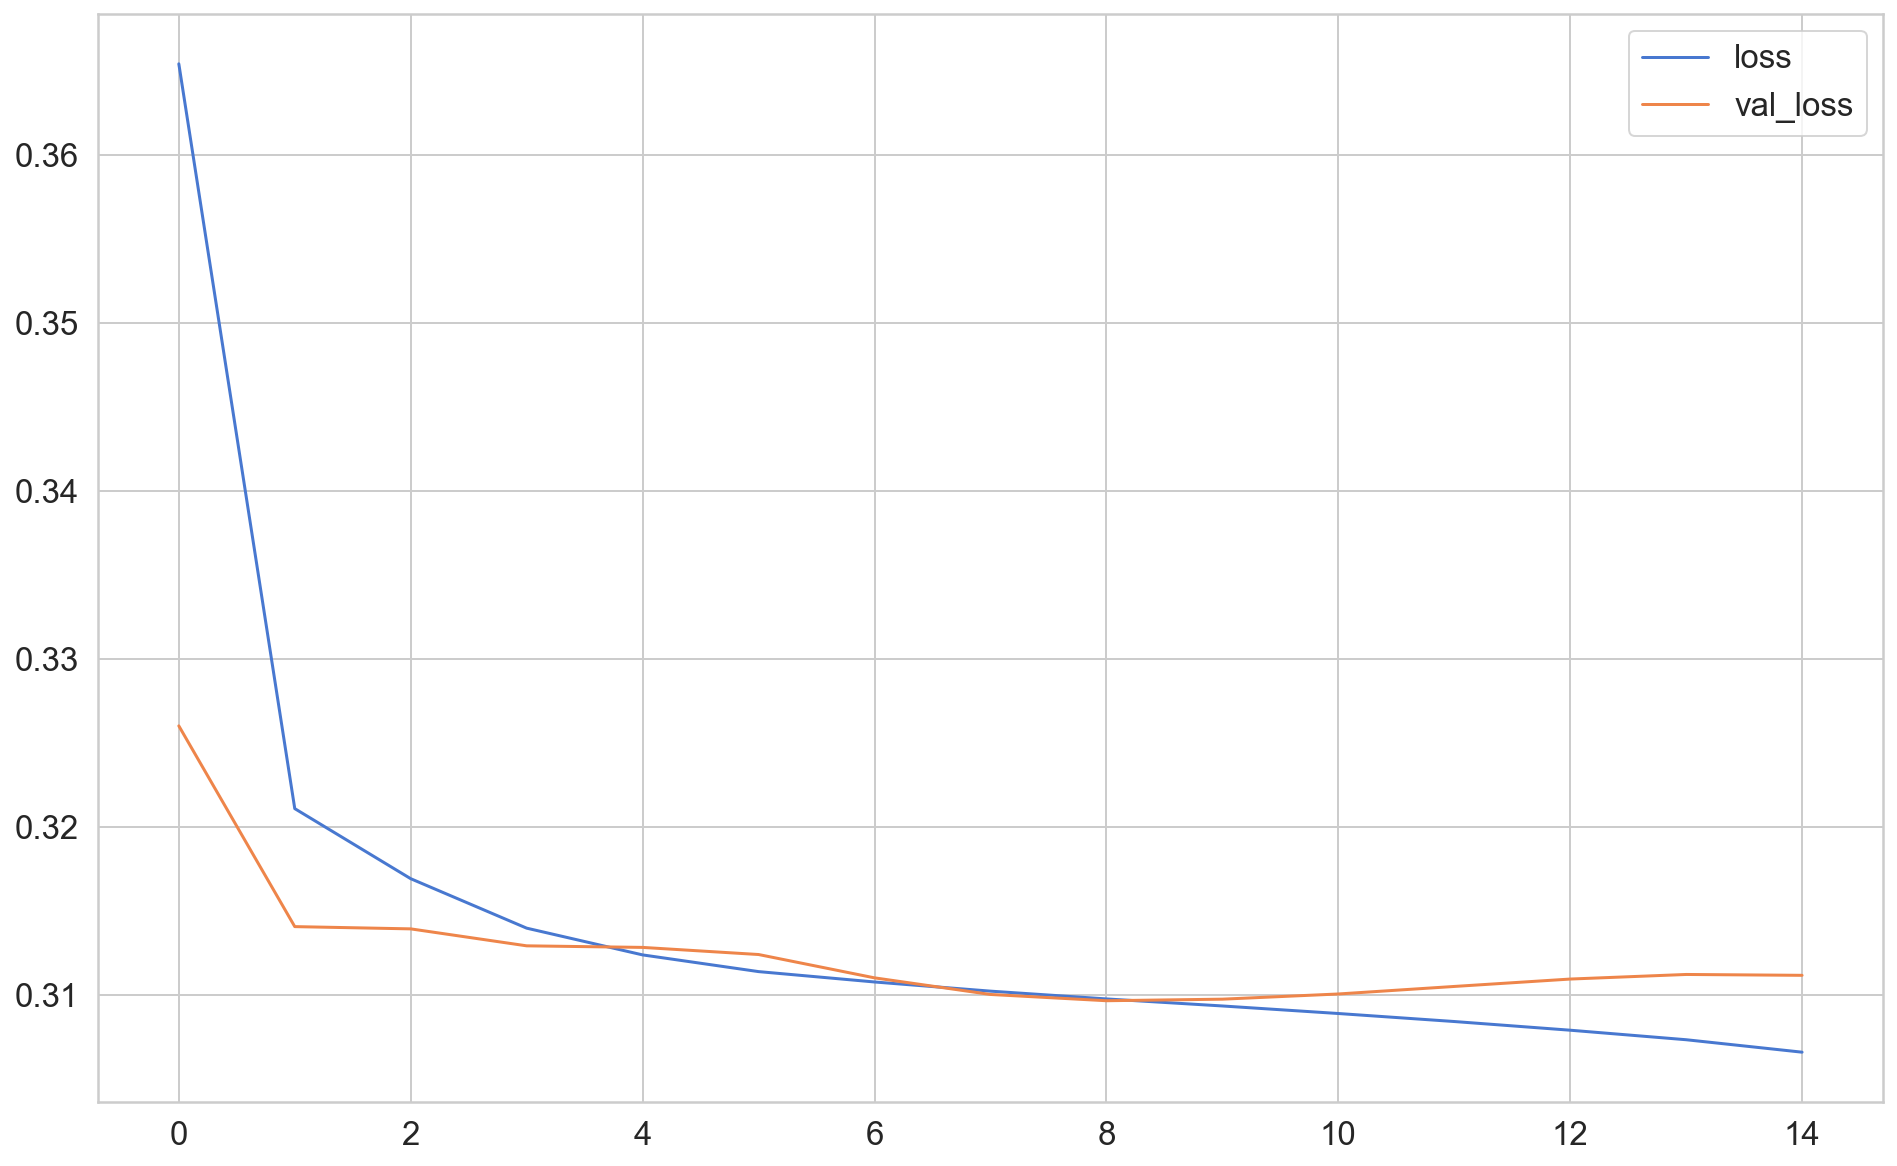

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'], loc = 'upper right') #it's overfitting after 15, let's just adjust that in the code above
plt.show()

In [20]:
y_pred_stacked = model2.predict(X_test)

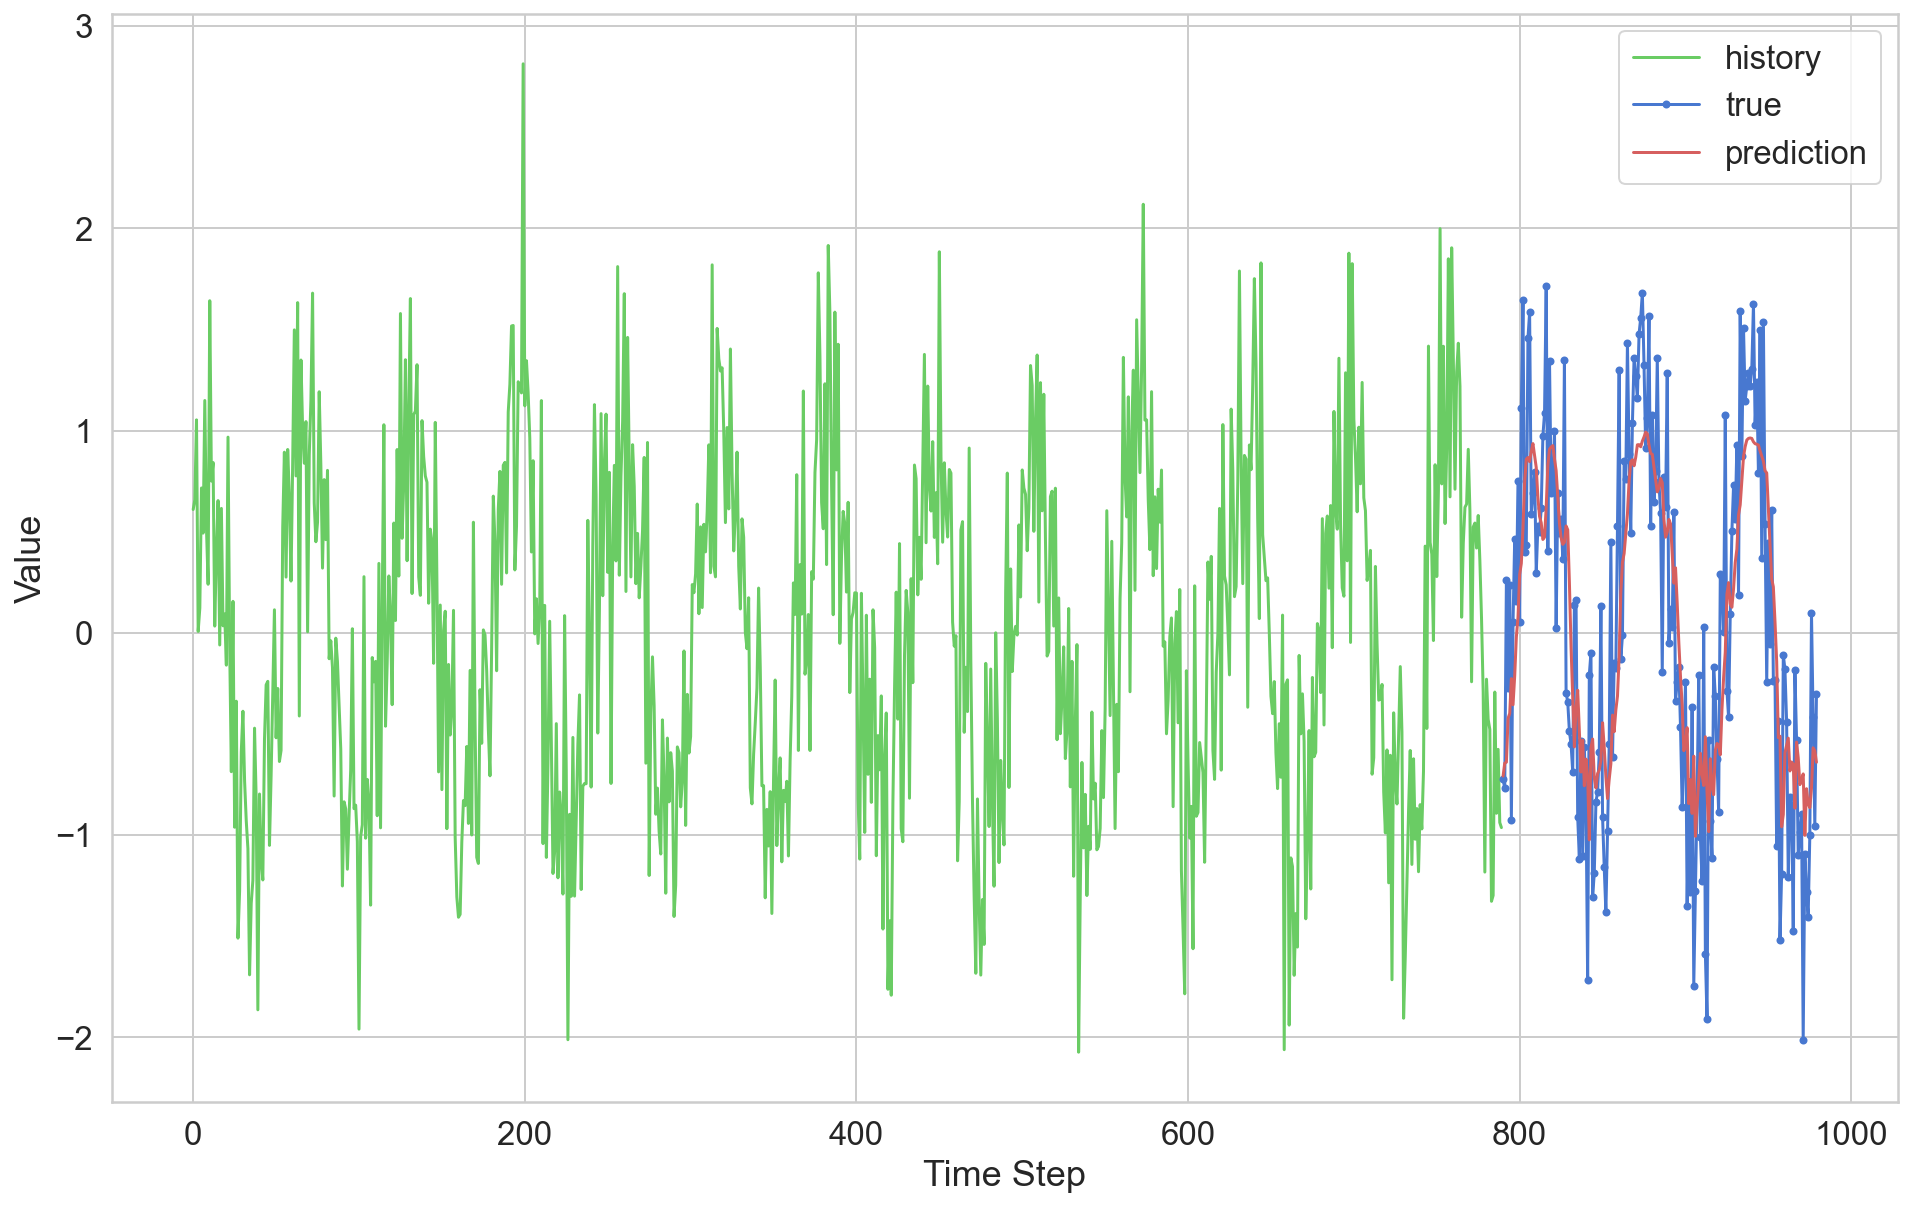

In [21]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label = 'history')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, marker = '.', label = 'true')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred_stacked, 'r', label = 'prediction')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

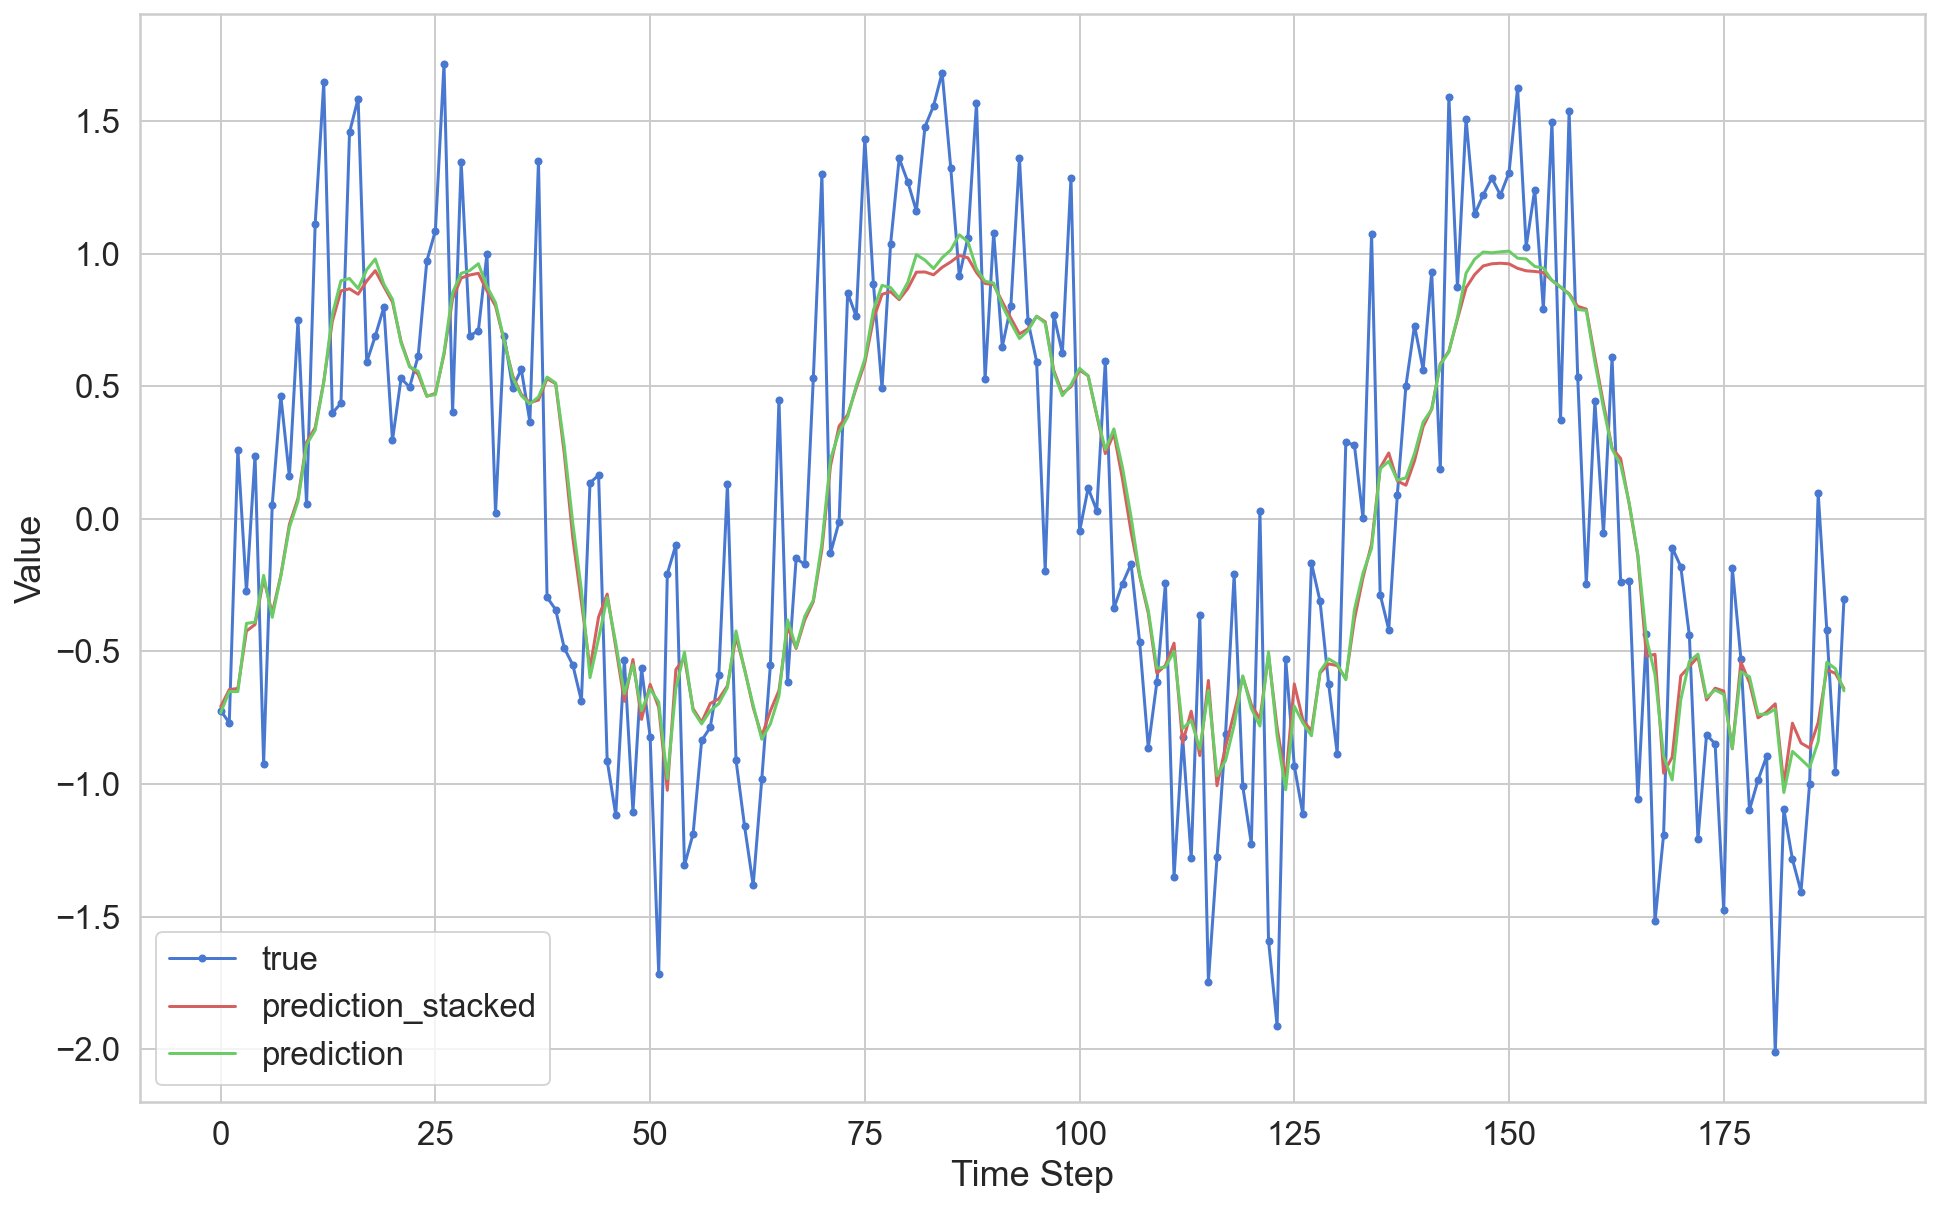

In [24]:
#let's zoom in
plt.plot(y_test, marker = '.', label = 'true')
plt.plot(y_pred_stacked, 'r', label = 'prediction_stacked')
plt.plot(y_pred, 'g', label = 'prediction')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [25]:
#let's stack a third one haha
model3 = keras.Sequential([
    keras.layers.LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True),
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.LSTM(units = 128),
    keras.layers.Dense(units = 1)
])

#adam = keras.optimizers.Adam(0.001) #lr

model3.compile(loss = 'mean_squared_error', optimizer = adam)

In [26]:
history = model3.fit(X_train, y_train, epochs = 15, batch_size = batch_size, validation_split = 0.1,
                   verbose = 2, shuffle = False)  #shuffle always FALSE with time series data!!!

Epoch 1/15
45/45 - 5s - loss: 0.4554 - val_loss: 0.3648
Epoch 2/15
45/45 - 2s - loss: 0.3279 - val_loss: 0.3149
Epoch 3/15
45/45 - 2s - loss: 0.3166 - val_loss: 0.3138
Epoch 4/15
45/45 - 2s - loss: 0.3145 - val_loss: 0.3125
Epoch 5/15
45/45 - 2s - loss: 0.3118 - val_loss: 0.3142
Epoch 6/15
45/45 - 2s - loss: 0.3107 - val_loss: 0.3135
Epoch 7/15
45/45 - 2s - loss: 0.3096 - val_loss: 0.3138
Epoch 8/15
45/45 - 2s - loss: 0.3089 - val_loss: 0.3125
Epoch 9/15
45/45 - 2s - loss: 0.3078 - val_loss: 0.3119
Epoch 10/15
45/45 - 2s - loss: 0.3069 - val_loss: 0.3103
Epoch 11/15
45/45 - 2s - loss: 0.3057 - val_loss: 0.3080
Epoch 12/15
45/45 - 2s - loss: 0.3043 - val_loss: 0.3097
Epoch 13/15
45/45 - 2s - loss: 0.3041 - val_loss: 0.3056
Epoch 14/15
45/45 - 2s - loss: 0.3013 - val_loss: 0.3095
Epoch 15/15
45/45 - 2s - loss: 0.3006 - val_loss: 0.3042


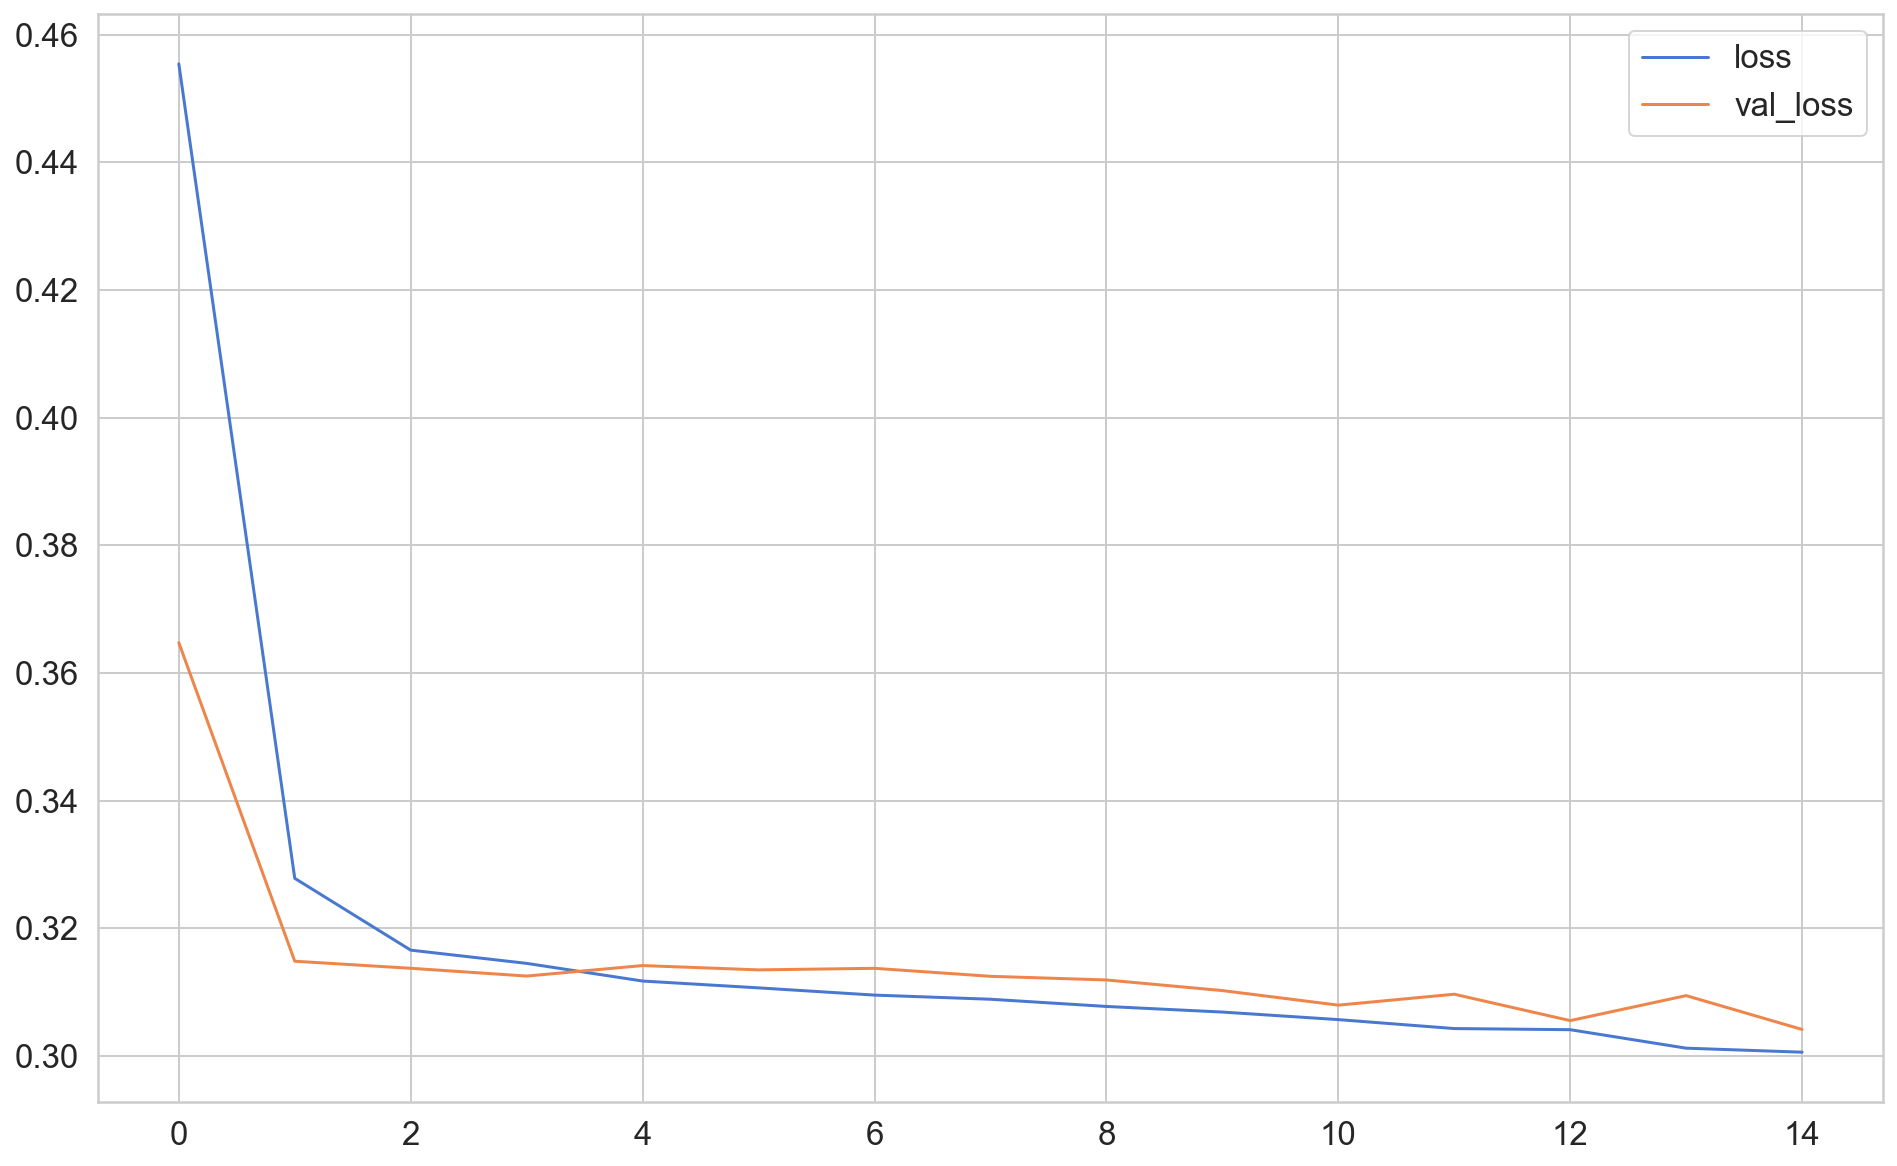

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'], loc = 'upper right') #it's overfitting after 15, let's just adjust that in the code above
plt.show()

In [28]:
y_pred_stacked2 = model3.predict(X_test)

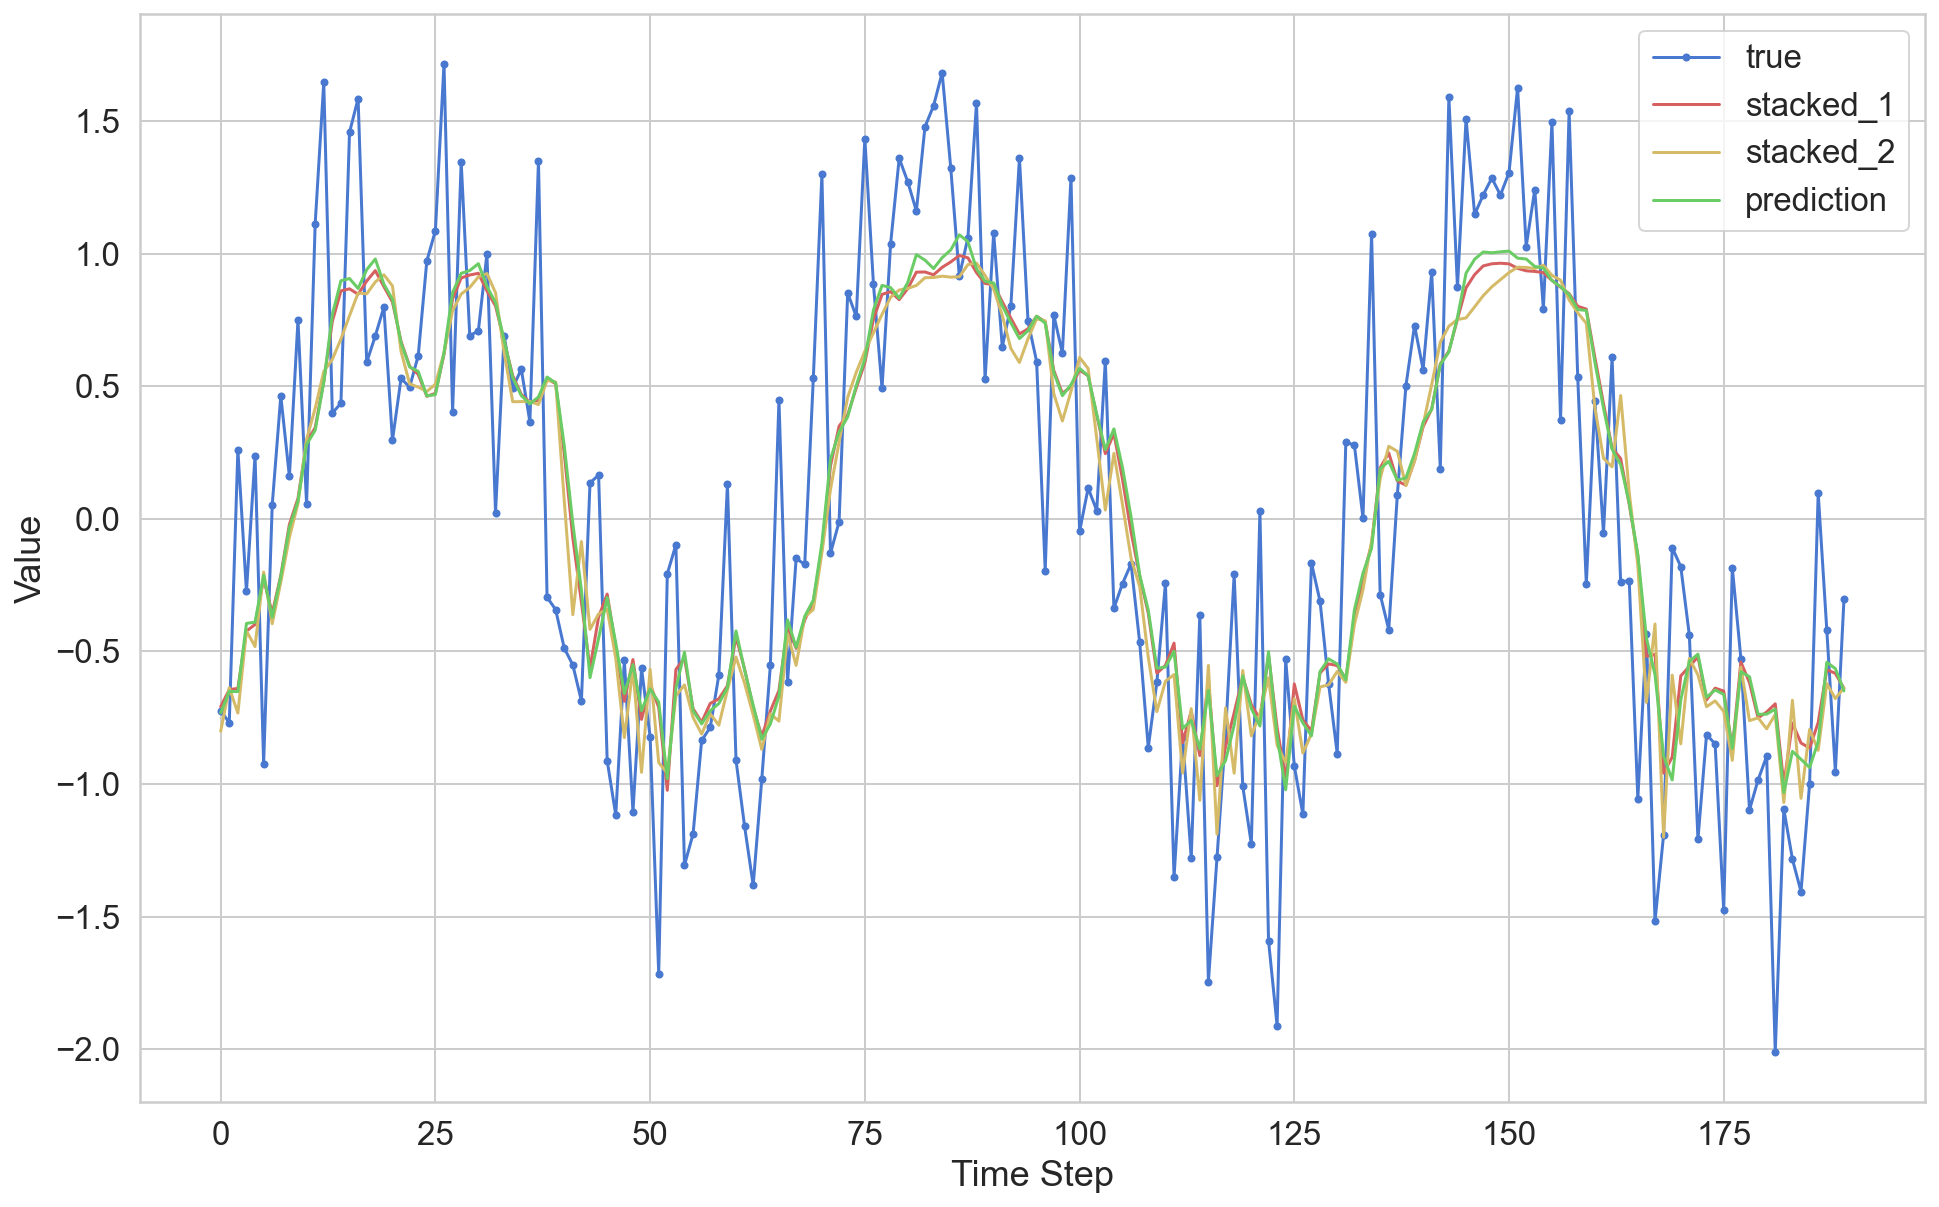

In [30]:
plt.plot(y_test, marker = '.', label = 'true')
plt.plot(y_pred_stacked, 'r', label = 'stacked_1')
plt.plot(y_pred_stacked2, 'y', label = 'stacked_2')
plt.plot(y_pred, 'g', label = 'prediction')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

the model with three layers seems to be better at seeing annomalies, BUT does not generalize as well. Might be good to use with similar situations, but in general it can be considered overfitted. 